# Home Credit Default Risk Analysis

Goal of the project:

Given Lending Club data on 2M+ loans, what drives a loan to default? Can we build a model that would identify problematic loans early on?

Background knowledge:

The term “default” lacks specificity, as many credit card companies have moved away from using it to describe overdue card payments. In the strictest terms, an account is in default if you haven’t made a payment by the due date. However, the term has come to be used to describe any debt that the card issuer no longer expects to be paid in full.

When a credit card company has decided that the outstanding debt they’re owed is unlikely to be paid at all, they will typically “charge-off” the debt. What this means to the card issuer is the entire amount of the outstanding debt, plus interest and fees, goes onto their books as an uncollectable debt.

Target:

Out target then is to predict Charged Off and Defaults together, collectively, they will represent "bad" loans.

## Structure of the project

Now that we have an idea what a "bad" loan is, let us define labels for bad loans:
- Charged Off
- Default
- Late (31-120 days)

Let's do the same for good loans and provide some definition. For the purposes of this analysis, we choose good loans to have the following charachteristics:
- Fully Paid
- Late (16-30 days)

<b> We will thus ignore In Grace Period and Current loans, as we do not know whether they are "good" or "bad" and they will confuse our model. <\b>


In [3]:
# Standard for Data
import pandas as pd
import numpy as np
import math
import pandas.api.types as ptypes

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# Machine
import os

# Aesthetics for Coding
import warnings
warnings.simplefilter(action='ignore', category = DeprecationWarning)
warnings.simplefilter(action='ignore', category = FutureWarning)

In [4]:
os.getcwd()

'/Users/nyatchen/Desktop/PyProjects/Lending_Club_Project'

# Loading data

In [6]:
#df_raw = pd.read_csv('loan.csv', low_memory = False)

In [7]:
# to save fast
#os.makedirs('tmp', exist_ok = True)
#df_raw.to_feather('tmp/raw')

In [5]:
df_raw = pd.read_feather('tmp/raw')

In [6]:
df_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN


In [7]:
df_raw.shape

(2260668, 145)

In [25]:
total_loan_status = df_raw.loan_status.copy()
total_loan_status.groupby(total_loan_status).count()

loan_status
Charged Off                                             261655
Current                                                 919695
Default                                                     31
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1041952
In Grace Period                                           8952
Late (16-30 days)                                         3737
Late (31-120 days)                                       21897
Name: loan_status, dtype: int64

In [26]:
a = sum(total_loan_status.groupby(total_loan_status).count())

# Create train and test sets
We will first "clean" loan_status columns for the entire dataset to abide by our abovementioned project structure. First, we will get rid of "Does not meet the credit policy. Status:" and only leave Charged Off and Fully Paid.

In [15]:
ls_clean_df = df_raw.copy()

In [16]:
temp = ls_clean_df.loan_status.str.extract(pat = r':(.*)', expand = False).dropna()

In [17]:
ls_clean_df.loc[temp.index, 'loan_status'] = temp
ls_clean_df = ls_clean_df.loc[~(ls_clean_df.loan_status == 'Current') & ~(ls_clean_df.loan_status == 'In Grace Period'),:]

In [27]:
total_loan_status = ls_clean_df.loan_status.copy()
total_loan_status.groupby(total_loan_status).count()

loan_status
Charged Off            262416
Default                    31
Fully Paid            1043940
Late (16-30 days)        3737
Late (31-120 days)      21897
Name: loan_status, dtype: int64

In [28]:
b = sum(total_loan_status.groupby(total_loan_status).count())

In [31]:
test_df = ls_clean_df.sample(frac = 0.2, random_state = 101)
use_set = ls_clean_df[~ls_clean_df.index.isin(test_df.index)]

# Cleaning data

In [36]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000, "display.max_colwidth", 1000): 
        display(df)


In [34]:
def percent_null(df):
    num_null = pd.Series([sum(df[col].isnull()) for col in df.columns])
    percent_null_df = pd.DataFrame({'col':df.columns, 'Missing Values':num_null, 
                                    '% of Total Values':100*num_null/len(df)}).sort_values(by = '% of Total Values', ascending=False)
    percent_null_df = percent_null_df.loc[percent_null_df['% of Total Values'] != 0].round(1)
    percent_null_df.set_index('col', inplace = True)
    percent_null_df.index.name = None
    return percent_null_df
percent_null_df = percent_null(use_set)
display_all(percent_null_df)

,Missing Values,% of Total Values
id,1065617,100.0
member_id,1065617,100.0
url,1065617,100.0
orig_projected_additional_accrued_interest,1061491,99.6
sec_app_mths_since_last_major_derog,1060055,99.5
hardship_reason,1059817,99.5
payment_plan_start_date,1059817,99.5
hardship_type,1059817,99.5
hardship_status,1059817,99.5
deferral_term,1059817,99.5


In [37]:
len(percent_null_df.index)

113

In [38]:
to_del = list(percent_null_df[percent_null_df['% of Total Values'] > 50.0].index); len(to_del)

58

In [39]:
work_df = use_set.copy().drop(to_del,axis = 1)
target = work_df.loan_status.copy()
work_df.drop('loan_status', axis = 1, inplace = True)

In [40]:
print(work_df.shape)
print(target.shape)

(1065617, 86)
(1065617,)


### It is helpful to know what each columns means

In [41]:
var_description = pd.read_excel('LCDataDictionary.xlsx')

In [42]:
display_all(var_description)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [43]:
var_description.dropna(inplace = True)

In [142]:
display_all(var_description[var_description.LoanStatNew.str.contains('total_rec_')])

,LoanStatNew,Description
107,total_rec_int,Interest received to date
108,total_rec_late_fee,Late fees received to date
109,total_rec_prncp,Principal received to date


## Exploring data

Text(0, 0.5, 'Data type')

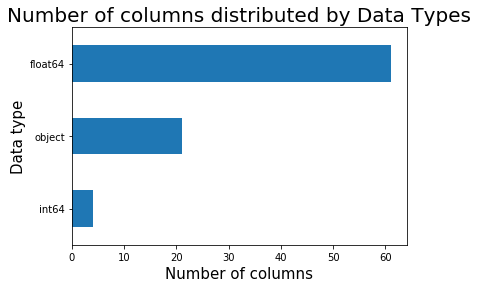

In [45]:
# Number of dtype of each kind
work_df.dtypes.value_counts().sort_values().plot(kind = 'barh');
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

### Add more data exploration if deemed necessary

We have quite a few object type columns, which we need to deal with. Let's see how many unique values with have in each

In [46]:
work_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                         2
grade                        7
sub_grade                   35
emp_title               315218
emp_length                  11
home_ownership               6
verification_status          3
issue_d                    139
pymnt_plan                   2
purpose                     14
title                    52231
zip_code                   939
addr_state                  51
earliest_cr_line           732
initial_list_status          2
last_pymnt_d               135
last_credit_pull_d         138
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

In [52]:
# Fixing time variables
list_time_vars = list(work_df.columns[work_df.columns.str.contains('_d')])

for c in list_time_vars:
    work_df[c] = work_df[c].fillna(0)
    work_df[c] = pd.to_datetime(work_df[c], infer_datetime_format=True).astype('int64')

In [53]:
work_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                         2
grade                        7
sub_grade                   35
emp_title               315218
emp_length                  11
home_ownership               6
verification_status          3
pymnt_plan                   2
purpose                     14
title                    52231
zip_code                   939
addr_state                  51
earliest_cr_line           732
initial_list_status          2
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

In [54]:
more_to_del = ['emp_title', 'title', 'last_credit_pull_d']
work_df = work_df.drop(more_to_del, axis = 1)

In [55]:
# Dealing with individual columns
work_df.emp_length = work_df.emp_length.str.extract('([0-9]{1,2})', expand = False).fillna(value = 0).astype('int')
work_df.term = work_df.term.str.extract('([0-9]{1,2})', expand = False).fillna(value = 0).astype('int')
work_df.grade = pd.Categorical(work_df.grade, ordered = True, categories = sorted(work_df.grade.unique(), reverse = True))
work_df.sub_grade = pd.Categorical(work_df.sub_grade, ordered = True, categories = sorted(work_df.sub_grade.unique(), reverse = True))

In [56]:
display_all(work_df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
100,30000,30000,30000.0,36,22.35,1151.16,D,D5,5,MORTGAGE,100000.0,Source Verified,1543622400000000000,n,debt_consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.442500,30026.44,30000.0,26.44,0.0,0.0,0.0,1546300800000000000,30082.32,0.0,1,Joint App,0,0.0,472330.0,42200.0,4.0,42939.0,15181.0,46.9,0.0,0.0,83.0,73.0,23.0,2.0,1.0,23.0,8.0,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0,2.0,89,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,N,Cash,N
152,40000,40000,40000.0,60,16.14,975.71,C,C4,1,MORTGAGE,45000.0,Verified,1543622400000000000,n,credit_card,456xx,OH,50.53,0.0,Jun-2009,0.0,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.678960,40856.68,40000.0,856.68,0.0,0.0,0.0,1548979200000000000,40910.48,0.0,1,Joint App,0,0.0,271068.0,54200.0,5.0,15059.0,14930.0,67.3,0.0,0.0,114.0,70.0,2.0,2.0,1.0,2.0,9.0,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0,4.0,100,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,N,Cash,N
215,8425,8425,8425.0,36,27.27,345.18,E,E5,3,MORTGAGE,450000.0,Verified,1543622400000000000,n,credit_card,020xx,MA,12.37,0.0,Oct-1997,0.0,21.0,0.0,36812,65.7,37.0,w,0.0,0.0,8735.148975,8735.15,8425.0,310.15,0.0,0.0,0.0,1548979200000000000,8754.30,0.0,1,Joint App,0,0.0,690320.0,56000.0,10.0,34516.0,11632.0,74.6,0.0,0.0,254.0,89.0,12.0,12.0,4.0,18.0,4.0,0.0,6.0,8.0,8.0,10.0,16.0,13.0,17.0,8.0,21.0,0.0,0.0,0,2.0,100,50.0,0.0,0.0,768304.0,189194.0,45800.0,189054.0,N,Cash,N
269,20000,20000,20000.0,60,17.97,507.55,D,D1,4,RENT,57000.0,Not Verified,1543622400000000000,n,debt_consolidation,981xx,WA,22.18,0.0,Apr-1995,0.0,10.0,0.0,33356,45.9,16.0,w,0.0,0.0,20013.577333,20013.58,20000.0,13.58,0.0,0.0,0.0,1546300800000000000,20043.53,0.0,1,Individual,0,0.0,33356.0,72700.0,3.0,3336.0,32170.0,50.4,0.0,0.0,78.0,284.0,5.0,5.0,1.0,27.0,17.0,0.0,4.0,7.0,6.0,9.0,1.0,10.0,14.0,7.0,10.0,0.0,0.0,0,2.0,100,33.3,0.0,0.0,72700.0,33356.0,64800.0,0.0,N,Cash,N
271,6600,6600,6325.0,36,11.31,217.05,B,B3,10,RENT,45000.0,Not Verified,1543622400000000000,n,credit_card,750xx,TX,16.21,0.0,Apr-2009,0.0,6.0,0.0,6167,58.2,13.0,f,0.0,0.0,6622.809000,6346.86,6600.0,22.81,0.0,0.0,0.0,1546300800000000000,6629.03,0.0,1,Individual,0,0.0,26836.0,10600.0,2.0,4473.0,4433.0,58.2,0.0,0.0,116.0,108.0,18.0,18.0,0.0,18.0,NaN,0.0,2.0,2.0,4.0,4.0,5.0,4.0,8.0,2.0,6.0,0.0,0.0,0,0.0,84,50.0,0.0,0.0,38607.0,26836.0,10600.0,28007.0,N,Cash,N


In [58]:
# Converting object variables into categorical and imputing NA values
max_n_cat = 7
for n,c in work_df.items():
    if ptypes.is_numeric_dtype(c):
        if pd.isnull(c).sum():
            work_df[n+'_na'] = pd.isnull(c)
            work_df[n] = c.fillna(c.median())
    if not ptypes.is_numeric_dtype(c):
        temp = c.astype('category').cat.as_ordered()
        if len(temp.cat.categories) > max_n_cat:
            work_df[n] = c.astype('category').cat.as_ordered()
            work_df[n] = work_df[n].cat.codes + 1
work_df = pd.get_dummies(work_df, dummy_na = True)

In [59]:
display_all(work_df.isnull().sum().sort_index()/len(work_df))

acc_now_delinq                         0.0
acc_open_past_24mths                   0.0
acc_open_past_24mths_na                0.0
addr_state                             0.0
annual_inc                             0.0
annual_inc_na                          0.0
application_type_Individual            0.0
application_type_Joint App             0.0
application_type_nan                   0.0
avg_cur_bal                            0.0
avg_cur_bal_na                         0.0
bc_open_to_buy                         0.0
bc_open_to_buy_na                      0.0
bc_util                                0.0
bc_util_na                             0.0
chargeoff_within_12_mths               0.0
chargeoff_within_12_mths_na            0.0
collection_recovery_fee                0.0
collections_12_mths_ex_med             0.0
collections_12_mths_ex_med_na          0.0
debt_settlement_flag_N                 0.0
debt_settlement_flag_Y                 0.0
debt_settlement_flag_nan               0.0
delinq_2yrs

In [60]:
display_all(work_df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,annual_inc_na,dti_na,delinq_2yrs_na,inq_last_6mths_na,open_acc_na,pub_rec_na,revol_util_na,total_acc_na,collections_12_mths_ex_med_na,tot_coll_amt_na,tot_cur_bal_na,total_rev_hi_lim_na,acc_open_past_24mths_na,avg_cur_bal_na,bc_open_to_buy_na,bc_util_na,chargeoff_within_12_mths_na,delinq_amnt_na,mo_sin_old_il_acct_na,mo_sin_old_rev_tl_op_na,mo_sin_rcnt_rev_tl_op_na,mo_sin_rcnt_tl_na,mort_acc_na,mths_since_recent_bc_na,mths_since_recent_inq_na,num_accts_ever_120_pd_na,num_actv_bc_tl_na,num_actv_rev_tl_na,num_bc_sats_na,num_bc_tl_na,num_il_tl_na,num_op_rev_tl_na,num_rev_accts_na,num_rev_tl_bal_gt_0_na,num_sats_na,num_tl_120dpd_2m_na,num_tl_30dpd_na,num_tl_op_past_12m_na,percent_bc_gt_75_na,pub_rec_bankruptcies_na,tax_liens_na,tot_hi_cred_lim_na,total_bal_ex_mort_na,total_bc_limit_na,total_il_high_credit_limit_na,grade_G,grade_F,grade_E,grade_D,grade_C,grade_B,grade_A,grade_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,pymnt_plan_n,pymnt_plan_y,pymnt_plan_nan,initial_list_status_f,initial_list_status_w,initial_list_status_nan,application_type_Individual,application_type_Joint App,application_type_nan,hardship_flag_N,hardship_flag_Y,hardship_flag_nan,disbursement_method_Cash,disbursement_method_DirectPay,disbursement_method_nan,debt_settlement_flag_N,debt_settlement_flag_Y,debt_settlement_flag_nan
100,30000,30000,30000.0,36,22.35,1151.16,16,5,100000.0,1543622400000000000,3,858,5,30.46,0.0,303,0.0,11.0,1.0,15603,37.0,19.0,0.0,0.0,30026.442500,30026.44,30000.0,26.44,0.0,0.0,0.0,1546300800000000000,30082.32,0.0,1,0,0.0,472330.0,42200.0,4.0,42939.0,15181.0,46.9,0.0,0.0,83.0,73.0,23.0,2.0,1.0,23.0,8.0,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0,2.0,89,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0
152,40000,40000,40000.0,60,16.14,975.71,22,1,45000.0,1543622400000000000,2,442,36,50.53,0.0,422,0.0,18.0,0.0,34971,64.5,37.0,0.0,0.0,40856.678960,40856.68,40000.0,856.68,0.0,0.0,0.0,1548979200000000000,40910.48,0.0,1,0,0.0,271068.0,54200.0,5.0,15059.0,14930.0,67.3,0.0,0.0,114.0,70.0,2.0,2.0,1.0,2.0,9.0,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0,4.0,100,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

# First Random Forest

In [102]:
total_loan_status = target.copy()
total_loan_status.groupby(total_loan_status).count()

loan_status
Charged Off           209572
Default                   27
Fully Paid            835536
Late (16-30 days)       2968
Late (31-120 days)     17514
Name: loan_status, dtype: int64

In [110]:
209572+27+17514

227113

In [134]:
X = work_df.copy()
y = target.copy()
y[(y == 'Default') | (y == 'Charged Off') | (y == 'Late (31-120 days)')] = 1
y[~y.index.isin(y[y==1].index)] = 0
y = y.astype('int')

In [135]:
# Percent bad loans of total
100*sum(y)/len(y)

21.31281689387463

In [136]:
m_rf = RandomForestClassifier(n_jobs = -1)
m_rf.fit(X, y)
m_rf.score(X, y)

1.0

In [137]:
print(metrics.confusion_matrix(y, m_rf.predict(X)))

[[838504      0]
 [     0 227113]]


In [138]:
print(metrics.classification_report(y, m_rf.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    838504
           1       1.00      1.00      1.00    227113

    accuracy                           1.00   1065617
   macro avg       1.00      1.00      1.00   1065617
weighted avg       1.00      1.00      1.00   1065617



Even though the R^2 score is high, we may have an issue with overfitting. We haven't tested our model on validation sets and really do not have much of an idea how the model would perform on an unseen dataset. First, let us examine why the score is that high by looking at the most important features. Becuase we might as well have some data leakage.

In [139]:
feat_imp = pd.DataFrame({'feature':X.columns, 'imp':m_rf.feature_importances_}).sort_values(by = 'imp', ascending = False)
feat_imp.head()

,feature,imp
29,recoveries,0.188838
30,collection_recovery_fee,0.162230
26,total_rec_prncp,0.136645
32,last_pymnt_amnt,0.077314
24,total_pymnt,0.070218


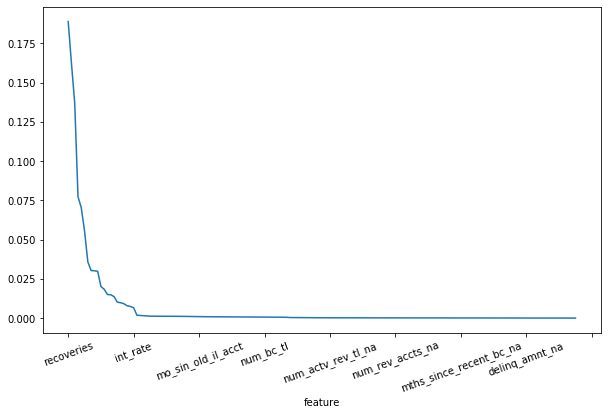

In [140]:
feat_imp.plot('feature', 'imp', figsize=(10,6), legend = False);
plt.xticks(rotation=20);

Recoveries and Collection_recovery_fee are the most important features. Let us dig in and understand what these two features are telling us.

Recoveries is post charge off gross recovery after an account is deemed no longer collectable as the borrower has become delinquent on payments. This essentially means it is default like. Therefore this featurecould be treated as one of the causes of data leakage. Plus, it probably wouldn't be too insightful to report that loan with recoveries are defaulting.

Next is collection_recovery_fee. This feature tells us what the collection fee is after charge off. Similar to above it indicates whether the loan is a severe risk category. Another example of data leakage.

Let us ,additionally, look at the correlation between recoveries and loan_status

In [141]:
to_check = pd.concat([X.recoveries, X.collection_recovery_fee, y], axis = 1)
to_check.corr()

,recoveries,collection_recovery_fee,loan_status
recoveries,1.000000,0.969483,0.474369
collection_recovery_fee,0.969483,1.000000,0.448636
loan_status,0.474369,0.448636,1.000000


# Creating train and validation sets

In [143]:
n = len(work_df)
y_train = target.groupby(target).apply(lambda x: x.sample(frac=0.7))
idx = y_train.index.get_level_values(1)
y_train.reset_index(drop=True, inplace = True)
y_train.index = idx

train_df = work_df.loc[list(idx)]
valid_df = work_df[~work_df.index.isin(train_df.index)]

In [144]:
X_train = train_df.copy()
X_valid = valid_df.copy()

y_valid = target[~target.index.isin(y_train.index)]

In [189]:
import math
def rmse(predicted, true_vals): return math.sqrt(((predicted-true_vals)**2).mean())

def print_score(m, X_t, X_v, y_t, y_v):
    train_pred = m.predict(X_t)
    valid_pred = m.predict(X_v)
    res = pd.DataFrame({'train_rmse':[rmse(train_pred, y_t)], 'valid_rmse':[rmse(valid_pred, y_v)],
                        'train_recall':[metrics.recall_score(y_t, train_pred)], 
                        'valid_recall':[metrics.recall_score(y_v, valid_pred)],
                        'train_accuracy':[metrics.accuracy_score(y_t, train_pred)],
                        'valid_accuracy':[metrics.accuracy_score(y_v, valid_pred)]
                       })
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    return res

In [146]:
y_train[(y_train == 'Default') | (y_train == 'Charged Off') | (y_train == 'Late (31-120 days)')] = 1
y_train[~y_train.index.isin(y_train[y_train==1].index)] = 0
y_train = y_train.astype('int')

y_valid[(y_valid == 'Default') | (y_valid == 'Charged Off') | (y_valid == 'Late (31-120 days)')] = 1
y_valid[~y_valid.index.isin(y_valid[y_valid==1].index)] = 0
y_valid = y_valid.astype('int')

In [147]:
m_rf_tr = RandomForestClassifier(n_jobs = -1)
m_rf_tr.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [151]:
print_score(m_rf_tr, X_train, X_valid, y_train, y_valid)

   train_rmse  valid_rmse  train_recall  valid_recall  train_accuracy  \
0         0.0     0.07443           1.0       0.98613             1.0   

   valid_accuracy  
0         0.99446  


In [152]:
feat_imp = pd.DataFrame({'feature':X_train.columns, 'imp':m_rf_tr.feature_importances_}).sort_values(by = 'imp', ascending = False)
feat_imp.head()

,feature,imp
29,recoveries,0.195664
26,total_rec_prncp,0.150803
30,collection_recovery_fee,0.129340
32,last_pymnt_amnt,0.091736
24,total_pymnt,0.056307


In [153]:
cl_rep = metrics.classification_report(y_valid, m_rf_tr.predict(X_valid))

In [154]:
print(cl_rep)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251551
           1       0.99      0.99      0.99     68134

    accuracy                           0.99    319685
   macro avg       0.99      0.99      0.99    319685
weighted avg       0.99      0.99      0.99    319685



We are definitely using data leakage to accurately predict bad loans. Next we will eliminate columns that we think are causing this leakage

## Feature Selection

In [155]:
from sklearn.ensemble import forest

def set_rf_samples(n): 
    """ Changes Scikit learn's random forests to give each tree a random sample of n random rows. """ 
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples(): 
    """ Undoes the changes produced by set_rf_samples. """ 
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [156]:
set_rf_samples(50000)

In [171]:
# nl for no leakage
leak_feat = ['recoveries', 'collection_recovery_fee', 'total_rec_prncp']
X_train_nl = X_train.copy().drop(leak_feat, axis = 1)
X_valid_nl = X_valid.copy().drop(leak_feat, axis = 1)

In [181]:
round(y_valid.value_counts()/len(y_valid)*100, 1)

0    78.7
1    21.3
Name: loan_status, dtype: float64

Our validation dataset is relatively balanced, thus using accuracy metric is appropriate.

In [172]:
m_rf_nl = RandomForestClassifier(n_jobs = -1)
m_rf_nl.fit(X_train_nl, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [173]:
display_all(print_score(m_rf_nl, X_train_nl, X_valid_nl, y_train, y_valid))

   train_rmse  valid_rmse  train_recall  valid_recall  train_accuracy  \
0    0.001637    0.109598      0.999987      0.955822        0.999997   

   valid_accuracy  
0        0.987988  


None

In [174]:
feat_imp_nl = pd.DataFrame({'feature':X_train_nl.columns, 'imp':m_rf_nl.feature_importances_}).sort_values(by = 'imp', ascending = False)
feat_imp_nl.head()

,feature,imp
29,last_pymnt_amnt,0.182659
24,total_pymnt,0.158355
25,total_pymnt_inv,0.137816
0,loan_amnt,0.048361
1,funded_amnt,0.047979


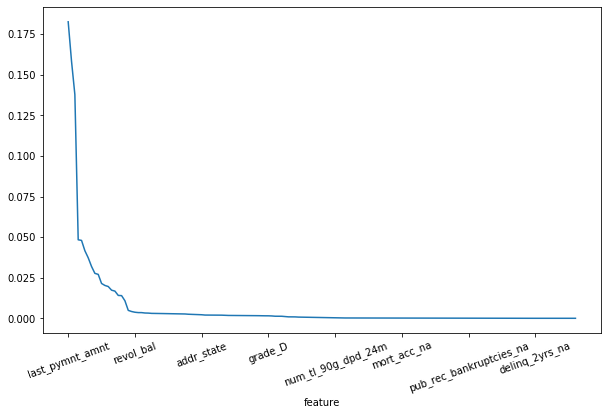

In [182]:
feat_imp_nl.plot('feature', 'imp', figsize=(10,6), legend = False);
plt.xticks(rotation=20);

In [185]:
to_keep = feat_imp_nl.feature[feat_imp_nl.imp > 0.005]
len(to_keepeep)

18

In [194]:
m_rf_nlv2 = RandomForestClassifier(n_jobs = -1)
m_rf_nlv2.fit(X_train_nl[to_keep], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [195]:
display_all(print_score(m_rf_nlv2, X_train_nl[to_keep], X_valid_nl[to_keep], y_train, y_valid))

,train_rmse,valid_rmse,train_recall,valid_recall,train_accuracy,valid_accuracy
0,0.001158,0.071054,1.0,0.982725,0.999999,0.994951


In [196]:
feat_imp_nl = pd.DataFrame({'feature':X_train_nl[to_keep].columns, 'imp':m_rf_nl.feature_importances_}).sort_values(by = 'imp', ascending = False)
feat_imp_nl

,feature,imp
0,last_pymnt_amnt,0.208466
1,total_pymnt,0.166546
2,total_pymnt_inv,0.131721
5,funded_amnt_inv,0.071110
4,funded_amnt,0.065305
6,installment,0.058320
3,loan_amnt,0.048160
12,term,0.035208
7,debt_settlement_flag_Y,0.033709
8,total_rec_int,0.033316


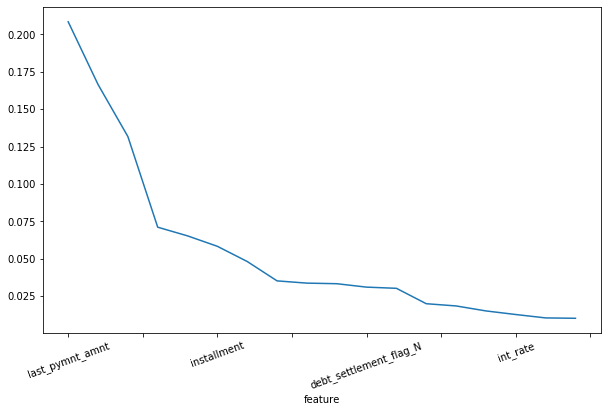

In [193]:
feat_imp_nl.plot('feature', 'imp', figsize=(10,6), legend = False);
plt.xticks(rotation=20);